# Imports

In [1]:
from XRDXRFutils import (Phase, DatabaseXRD, DataXRF, DataXRD, SpectraXRD, FastSpectraXRD, GaussNewton,
    PhaseList, ChiSearch, GammaMap, ChiMap, Phase, PhaseList, GammaSearch_Secondary, GammaMap_Secondary)

from os.path import isdir
from os import makedirs
from shutil import rmtree

import h5py
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit, least_squares

from numpy import (linspace, concatenate, sqrt, log, sin, pi, histogram, array, unravel_index, savetxt,
    flip, sum, average, amax, arange, empty, newaxis, clip, quantile)
import pandas as pd

from matplotlib.pyplot import (sca, show, fill_between, legend, imshow, subplots, plot, xlim, ylim,
    xlabel, ylabel, cm, title, scatter, colorbar, figure, vlines, savefig, get_cmap, hist)
from matplotlib import rcParams
from matplotlib.ticker import FuncFormatter, ScalarFormatter
from matplotlib.markers import MarkerStyle
from matplotlib.colors import BoundaryNorm
from matplotlib.lines import Line2D

from sklearn.cluster import KMeans, MiniBatchKMeans

from multiprocessing import Pool

from glob import glob
from PIL import Image

from pathlib import Path


def f_linear(x,a,b):
    return a*x + b


def f_loss(x,t,y):
    return (x[0]*t + x[1]) - y


def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)


def read_raw_XRD(path_xrd, filename_scanning = 'Scanning_Parameters.txt', filename_calibration = 'calibration.ini', filename_h5 = 'xrd.h5'):
    return (DataXRD().read_params(path_xrd + filename_scanning).read(path_xrd)
            .calibrate_from_file(path_xrd + filename_calibration).remove_background().save_h5(path_xrd + filename_h5))


def correct_point(experimental_phases, idx_phase, gm, x, y):
    gn = gm.get_pixel(x, y)[idx_phase]
    phase = gn.make_phase()
    phase.set_name('created_%d'%idx_phase)
    phase.set_point(gm.get_index(x, y))
    experimental_phases[idx_phase] = phase

    
def rename_phase_in_database(database, name_old, name_new):
    for p in database[name_old]:
        p['_chemical_name_mineral'] = name_new
    database[name_new] = database[name_old]
    del database[name_old]


def find_element(element, labels, allow_loose = True):
    for j, label in enumerate(labels):
        if (element + '_') in label:   # search for the given string + '_' in XRF label
            return j
    if allow_loose:
        for j, label in enumerate(labels):
            if element in label:   # search for the given string in XRF label
                return j
    return None


rcParams.update({
'image.origin': 'lower'
})

# Define paths and parameters

In [2]:
#path_shared = '/home/shared/'
path_shared = '../../shared/'

### Input ###
path_scan = path_shared + 'dataXRDXRF/MunchMuseum/M491/'
path_xrd = path_scan + 'ProfiloXRD/'           # XRD scan 
path_xrf = path_scan + 'ProfiloXRF/labels/'    # XRF scan
path_photo = path_scan + 'ProfiloFoto/'        # photo of the scanned section
path_zmap = path_shared + 'VenereBZPosition/'
path_database = path_shared + 'Database/'     # tabulated phases

### Output ###
subfolder_output = 'MunchMuseum/M491/Profilo/'
path_figures = 'figures/' + subfolder_output          # figures generated by the script
path_results = 'results/' + subfolder_output          # results generated by the script: raw data, tif maps
path_database_exp = 'databaseEXP/' + subfolder_output # experimental phases

### Parameters ###
min_theta = 20
max_theta = 53
min_intensity = 0.1  # among the tabulated peaks, selects only the ones above this threshold of intensity (scale between 0 and 1)
first_n_peaks = None # selects the first n most intense peaks (if None, leaves all the peaks)
sigma = 0.2          # sigma used in the peaks of synthetic diffraction patterns

#### To reset results, delete output folders.
WARNING: every previous result will be lost. Use only if you want to delete all files in the data folders

In [3]:
do_you_want_to_delete = False

if do_you_want_to_delete:
    if isdir(path_figures):
        rmtree(path_figures)
    if isdir(path_results):
        rmtree(path_results)
    if isdir(path_database_exp):
        rmtree(path_database_exp)

#### Check if output folders exist. If not, create them.

In [4]:
if not isdir(path_figures):
    makedirs(path_figures)
if not isdir(path_results):
    makedirs(path_results)
if not isdir(path_database_exp):
    makedirs(path_database_exp)

# Show photo of scanned section

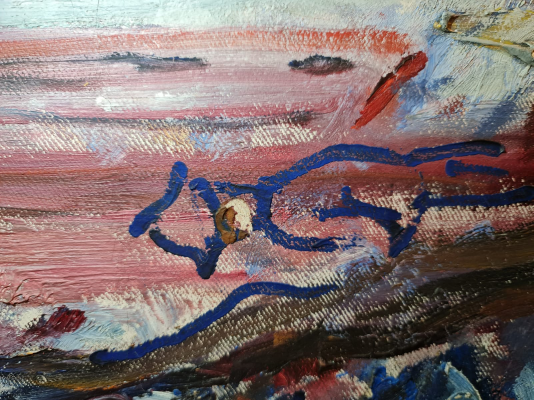

In [5]:
filenames = glob(path_photo + '*.jpg')
for filename in filenames:
    im = Image.open(filename)
    display(im.reduce(3))

# Read XRD Data and Database
To recalculate h5 file, change just for one time the filename that the cell tries to read (indicated by the comment)

In [6]:
%matplotlib inline
rcParams['font.size'] = 12

try:
    data = DataXRD().load_h5(path_xrd + 'xrd.h5') # to force the recalculation of h5 file, change this filename
    if any(not hasattr(data, attr) for attr in data.check_attributes):
        print('The present h5 file doesn\'t have all required information. Reading from raw data.')
        data = read_raw_XRD(path_xrd)
except:
    print('Reading from raw data.')
    data = read_raw_XRD(path_xrd)
    
print(f'Shape of data: {data.shape}')
print('Initial calibration:')
print(f'a = {data.opt[0]:.1f}, s = {data.opt[1]:.1f}, beta = {data.opt[2]:.3f}')
print(f'Theta range {list(data.fce_calibration([0, data.shape[2]], *data.opt))}')

database = DatabaseXRD().read_cifs(path_database)
print('\nPhases in database:', len(database))

Loading: ../../shared/dataXRDXRF/MunchMuseum/M491/ProfiloXRD/xrd.h5
Shape of data: (95, 170, 1280)
Initial calibration:
a = -1214.7, s = 1952.7, beta = 51.663
Theta range [19.77907407899562, 53.578190550653794]

Phases in database: 367


# Burnt pixels

### Show them
Choose a quantile on the value of maximum channel. All pixels above that quantile will be considered burnt pixel.

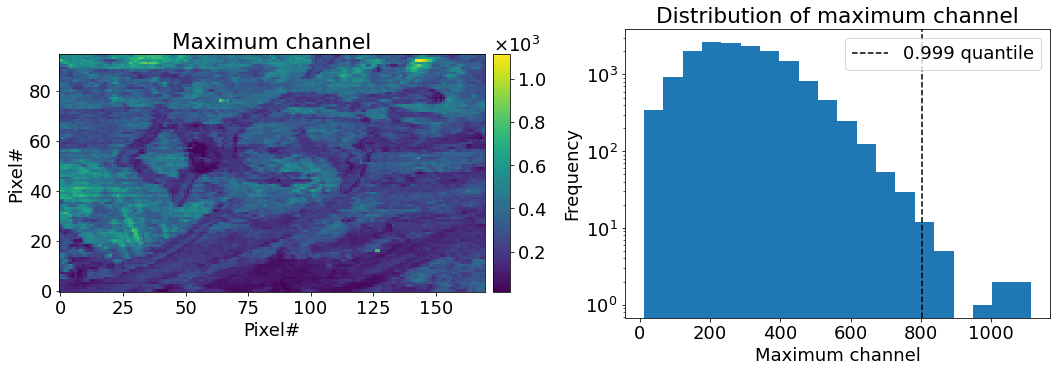

17 pixels out of 16150 are selected as burnt.


In [7]:
rcParams['font.size'] = 18

qtl = 0.999
#qtl = 1

data_max = (data.data - data.background).max(axis = 2)
indices_to_correct = data_max > quantile(data_max, qtl)

fig, axs = subplots(1, 2, figsize = (15, 5))
fig.tight_layout(w_pad = 5)

ax = axs[0]
data_to_process = data.data - data.background
im = ax.imshow(data_max, interpolation = 'none')
formatter = ScalarFormatter(useMathText = True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 3))
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.02, 0, 0.04, 1]), format = formatter)
cbar.ax.yaxis.set_offset_position('left')
ax.set_xlabel(r'Pixel#')
ax.set_ylabel(r'Pixel#')
ax.set_title('Maximum channel')

ax = axs[1]
ax.hist(data_max.flatten(), bins = 20)
ax.axvline(quantile(data_max, qtl), c = 'black', ls = '--', label = f'{qtl} quantile')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('Maximum channel')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of maximum channel')

show()
print(f'{indices_to_correct.sum()} pixels out of {data.shape[0] * data.shape[1]} are selected as burnt.')

### Correct them
Substitute burnt pixel with the average of the non burnt ones.

In [8]:
data.data[indices_to_correct] = data.data[~indices_to_correct].mean(axis = 0, keepdims = True)
data.background[indices_to_correct] = data.background[~indices_to_correct].mean(axis = 0, keepdims = True)
data.intensity[indices_to_correct] = data.intensity[~indices_to_correct].mean(axis = 0, keepdims = True)
data.signal_background_ratio[indices_to_correct] = data.signal_background_ratio[~indices_to_correct].mean(axis = 0, keepdims = True)
data.rescaling[indices_to_correct] = data.rescaling[~indices_to_correct].mean(axis = 0, keepdims = True)

print(f'{indices_to_correct.sum()} pixels out of {data.shape[0] * data.shape[1]} were corrected.')

17 pixels out of 16150 were corrected.


# Show aggregated information about XRD data

We process raw XRD data by subtracting the background (obtained by SNIP).
On this data we calculate aggregated information.

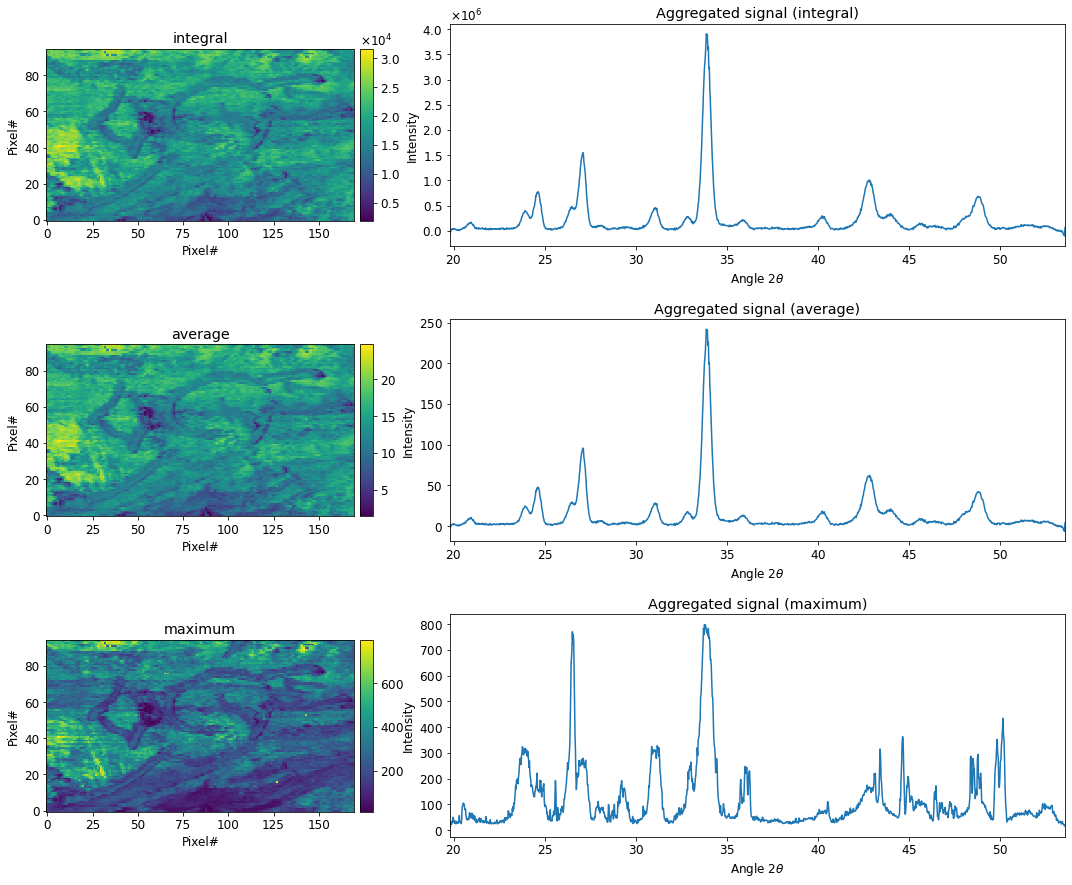

In [9]:
rcParams['font.size'] = 12

fig, axs = subplots(3, 2, figsize = (15, 12), gridspec_kw = {'width_ratios': [1, 2]})
fig.tight_layout(h_pad = 4, w_pad = 5)

theta = data.fce_calibration(range(data.shape[-1]), *data.opt)
list_aggregations = ['integral', 'average', 'maximum']
list_functions = [sum, average, amax]
data_to_process = data.data - data.background

for i in range(len(list_aggregations)):
    
    image_aggregated = list_functions[i](data_to_process, axis = 2)
    ax = axs[i, 0]
    im = ax.imshow(image_aggregated, interpolation = 'none')
    formatter = ScalarFormatter(useMathText = True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-2, 3))
    cb = colorbar(im, ax = ax, cax = ax.inset_axes([1.02,0, 0.04, 1]), format = formatter)
    cb.ax.yaxis.set_offset_position('left')
    ax.set_title(list_aggregations[i])
    ax.set_ylabel(r'Pixel#')
    ax.set_xlabel(r'Pixel#')
    
    xrdpattern_aggregated = list_functions[i](data_to_process, axis = (0, 1))
    ax = axs[i, 1]
    ax.plot(theta, xrdpattern_aggregated)
    ax.ticklabel_format(useMathText = True)
    ax.set_xlim(theta[0], theta[-1])
    ax.set_xlabel(r'Angle $2\theta$')
    ax.set_ylabel('Intensity')
    ax.set_title(f'Aggregated signal ({list_aggregations[i]})')

savefig(f'{path_figures}aggregated_info.png', bbox_inches = 'tight', dpi = 300)
show()

# Rescaling and signal / background ratio

- 'Rescaling' shows, for each pixel, the maximum value of the experimental diffraction pattern after we subtract the background.
This value is used to obtain the rescaled signal in the interval [0, 1].
That's why we indicate this value as 'rescaling'.

- 'Signal/Noise' indicates the integral of the experimental diffraction pattern divided by the integral of the background.

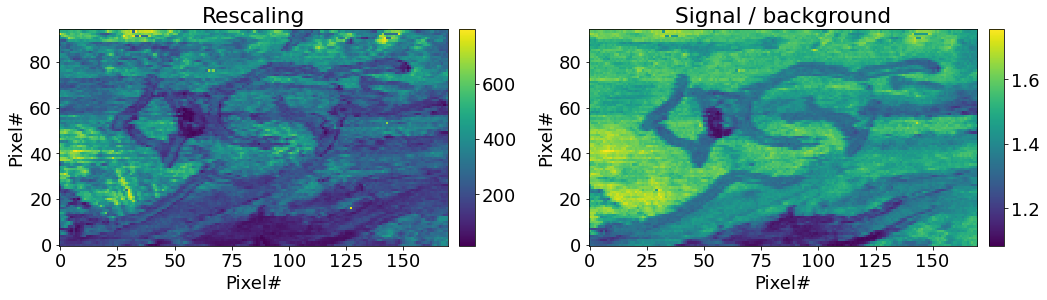

In [10]:
rcParams['font.size'] = 18

fig, axs = subplots(1, 2, figsize = (15, 4))
fig.tight_layout(w_pad = 1)

ax = axs[0]
im = ax.imshow(data.rescaling.squeeze(), interpolation = 'none')
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
ax.set_title('Rescaling')
ax.set_ylabel(r'Pixel#')
ax.set_xlabel(r'Pixel#')

ax = axs[1]
im = ax.imshow(data.signal_background_ratio.squeeze(), interpolation = 'none')
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
ax.set_title('Signal / background')
ax.set_ylabel(r'Pixel#')
ax.set_xlabel(r'Pixel#')

show()

# Read XRF images

If the orientation of tiff images does not correspond with XRD scans, flip them in this cell

In [11]:
data_xrf = DataXRF()
data_xrf.read_tiff(path_xrf)
data_xrf.labels = flip(data_xrf.labels, axis = [1]) # choose the axes to flip
print(f'Found {data_xrf.labels.shape[2]} images')

Found 24 images


### Correct burnt pixels in each XRF map
Choose a quantile on the value of XRF intensity. All pixels above that quantile will be corrected as burnt pixels and will be assigned the threshold value.

In [12]:
qtl = 0.999
#qtl = 1

qtl_calculated = quantile(data_xrf.labels, qtl, axis = (0, 1))[newaxis, newaxis, :]
n_corrected = (data_xrf.labels > qtl_calculated).sum() / data_xrf.labels.shape[-1]
data_xrf.labels = clip(data_xrf.labels, None, qtl_calculated)
print(f'{n_corrected:.0f} pixels out of {data_xrf.labels.shape[0] * data_xrf.labels.shape[1]} were corrected on average in each XRF map.')

17 pixels out of 16150 were corrected on average in each XRF map.


## Define phases

This is for simplification. Phases can be selected iteratively from database using 'Tab'

In [13]:
hydrocerussite = database['Hydrocerussite'][0]
hydrocerussite['associated elements'] = ['Pb']

lazurite = database['Lazurite'][0]
lazurite['associated elements'] = ['Si']

cinnabar = database['Cinnabar'][1]
cinnabar['associated elements'] = ['Hg', 'S']

### Check phases in a given point

Cinnabar (Hg S)


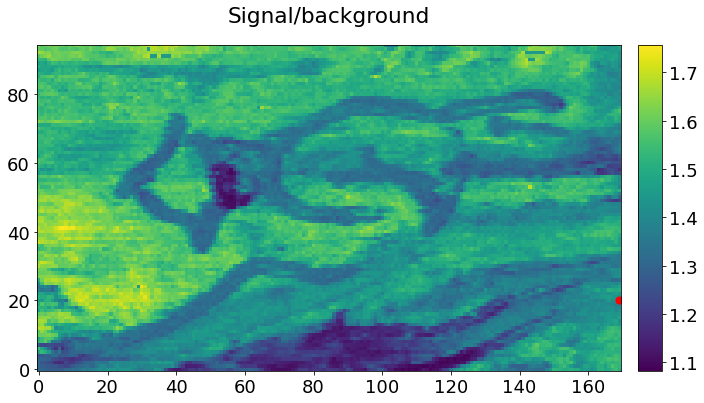

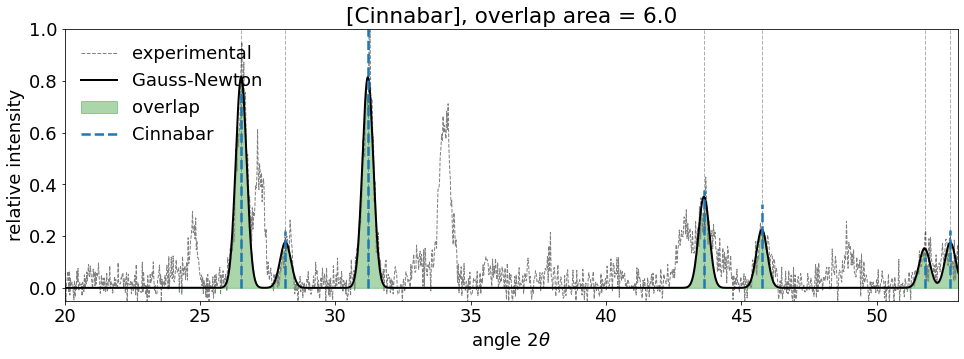

In [14]:
%matplotlib inline
x, y = 169, 20
#x, y = 0, 50
rcParams['font.size'] = 18

fig, ax = subplots(figsize = (15, 6))
im = ax.imshow(data.signal_background_ratio.squeeze(), interpolation = 'none')
ax.scatter(x, y, s = 50, c = 'red', marker = 'o')
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
ax.set_title('Signal/background', y=1.05)

phases_new = PhaseList([cinnabar])

for p in phases_new:
    print(p.label, end = '')
    if '_chemical_formula_sum' in p:
        print (' (' + p['_chemical_formula_sum'] + ')')

gn = GaussNewton(phases_new, FastSpectraXRD().from_Data(data, x, y), min_theta = min_theta, max_theta = max_theta,
    min_intensity = min_intensity, first_n_peaks = first_n_peaks, sigma = sigma)

### Leaves initial calibration and only optimizes the heights of the peaks ###
gn.fit_cycle(gamma = True, steps = 16)

### Optimizes calibration and heights of the peaks ###
#gn.fit_cycle(gamma = True, steps = 16).fit_cycle(a = True, s = True, gamma = True, steps = 16).fit_cycle(gamma = True, steps = 16)

fig, ax = subplots(figsize = (16, 5))
sca(ax)
gn.plot_spectrum(c = 'grey', ls = '--', lw = 1, label = 'experimental')
gn.plot(c = 'black', ls = '-', lw = 2, label = 'Gauss-Newton')
fill_between(gn.theta.squeeze(), gn.overlap(), color = 'g', alpha = 0.33, label = 'overlap')
gn.phase.plot(color = 'k', lw = 1, lineheight = 1, alpha = 0.3, label = '')
gn.phase.plot(lw = 2.5, alpha = 1)
ax.set_xlim(min_theta, max_theta)
ax.set_ylim(-0.05, 1)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel(r'relative intensity')
ax.set_title(f'{gn.label}, overlap area = {gn.overlap3_area():.1f}')
legend(frameon = False, loc = 2)
show()

# Search for primary phases

Adjust initial calibration. This can be executed after the first fit finds a better initial calibration.

### Change initial calibration

In [15]:
if 'pmax_a' in locals():
    data.opt[0] = pmax_a
    data.opt[1] = pmax_s

### Create data structure

In [16]:
phases_primary = [hydrocerussite, lazurite, cinnabar]

In [17]:
gm = GammaMap().from_data(data, phases_primary, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
    min_intensity = min_intensity, first_n_peaks = first_n_peaks)

### Autocalibration and search
Optimizes on $a,s$ and $\gamma$. Choses the best phase by overlap area and fits with respect to that.

In [18]:
%%time
gm = gm.search()
L1loss, MSEloss, overlap_area = gm.metrics()

Using 8 CPUs
Using 8 CPUs
CPU times: user 11 s, sys: 1.93 s, total: 13 s
Wall time: 20.2 s


#### Fast mapping

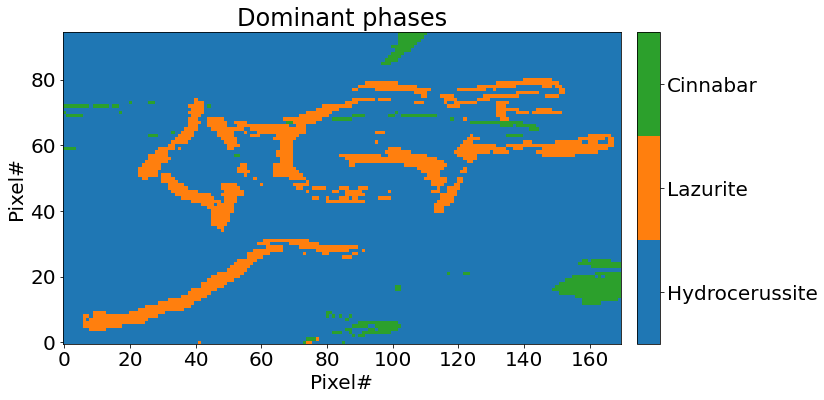

In [19]:
%matplotlib inline
rcParams['font.size'] = 20

fig, ax = subplots(figsize = (10, 6))
cmap_chosen = get_cmap('tab10')
norm_chosen = BoundaryNorm(arange(-0.5, len(phases_primary) + 0.5, 1), len(phases_primary))
im = imshow(gm.selected(), cmap = cmap_chosen, norm = norm_chosen, interpolation = 'none')
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
cbar.set_ticks(range(0, len(phases_primary)))
cbar.set_ticklabels([p.label for p in phases_primary])
ax.set_title('Dominant phases')
ax.set_xlabel(r'Pixel#')
ax.set_ylabel(r'Pixel#')

savefig(path_figures + 'fast_map_dominant_phases.png', bbox_inches = 'tight', dpi = 200)
show()

### Histogram of $a$

If $a$ is spead over too large area it means that fitting went wrong. Maybe we need to add phases.

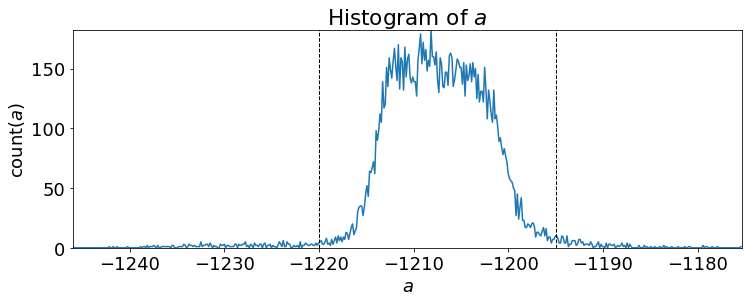

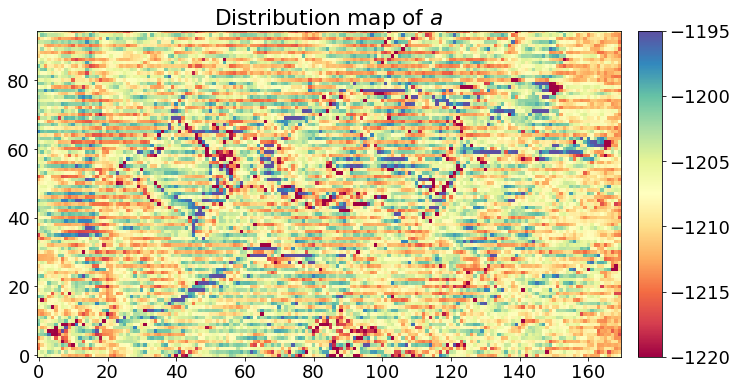

In [20]:
%matplotlib inline
rcParams['font.size'] = 18

opt = gm.opt()
a = opt[..., 0]
s = opt[..., 1]

### Set them for better representation of color map ###
vmin = -1220
vmax = -1195

h, b = histogram(a, bins = 512)

fig, ax = subplots(figsize = (12, 4))
ax.plot(b[:-1], h)
ax.set_xlim(b[0], b[-1])
#ax.set_xlim(-1230, -1180) # TO CHANGE HORIZONTAL SCALE: set these value, otherwise leave this line commented
ax.set_ylim(0, h.max())
ax.vlines(vmin, 0, h.max(), 'k', ls = '--', lw = 1)
ax.vlines(vmax, 0, h.max(), 'k', ls = '--', lw = 1)
ax.set_xlabel('$a$')
ax.set_ylabel(r'count($a$)')
ax.set_title(r'Histogram of $a$')
savefig(path_figures + f'histogram_a_ROI({vmin},{vmax}).png')

fig, ax = subplots(figsize = (12, 6))
ax.set_title('Distribution map of $a$')
im = ax.imshow(a, cmap = 'Spectral', interpolation = 'none', vmin = vmin, vmax = vmax)
colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
savefig(path_figures + f'distribution_map_a_ROI({vmin},{vmax}).png')

show()

## Plotting the $a,s$ dependence

There is a slight notion of a second $a, s$ dependence but it is weak.

Linear: [  -1.79597116 -219.93390074]
Cauchy: [ -0.90252648 857.86012077]
mean a,s: -1207.3345575986314 1948.4041480300689
most probable a,s: -1208.1677362854252 1948.263496458418


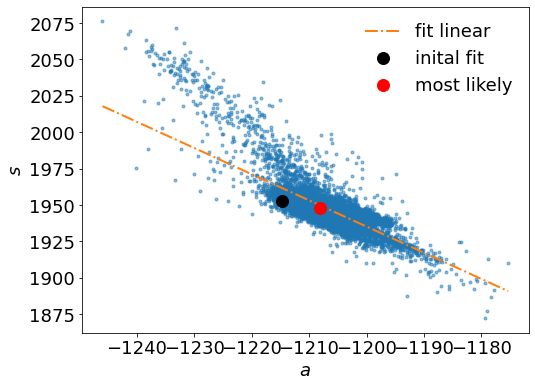

In [21]:
%matplotlib inline
rcParams['font.size'] = 18

opt, var = curve_fit(f_linear, a.flatten(), s.flatten())
res = least_squares(f_loss, x0 = opt, args = (a.flatten(), s.flatten()), loss = 'cauchy')
pmax_a = b[h.argmax()]
pmax_s = f_linear(pmax_a, *res['x'])
x = linspace(a.min(), a.max(), 10)
# linear_y = f_linear(a.flatten(), *opt)
# cauchy_y = f_linear(a.flatten(), *res['x'])

print('Linear:', opt)
print('Cauchy:', res['x'])
print('mean a,s:', a.mean(), s.mean())
print('most probable a,s:', pmax_a, pmax_s)

fig, ax = subplots(figsize = (8, 6))
ax.plot(a.flatten(), s.flatten(), '.', alpha = 0.5)
ax.plot(x, f_linear(x, *opt), '-.', lw = 2, label = 'fit linear')
#ax.plot(x, f_linear(x, *res['x']), '--', lw = 2, label = 'fit cauchy')
ax.plot(data.opt[0], data.opt[1], 'ko', ms = 12, label = 'inital fit')
ax.plot(pmax_a, pmax_s, 'ro', ms = 12, label = 'most likely')
ax.legend(frameon = False)
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$s$')

### TO SET HORIZONTAL AND VERTICAL SCALE ###
# If you prefer automatic scale, you can leave this options commented.
#ax.set_xlim(-1250, -1180)
#ax.set_ylim(1850, 2000)

savefig(path_figures + 'fit_a_s.png')
show()

### Quantify phase presence

In [22]:
correction = data.rescaling**0.5
#correction = data.signal_background_ratio

criterion = overlap_area * correction

presence_hydrocerussite = criterion[..., 0].copy()
presence_hydrocerussite /= presence_hydrocerussite.max()
presence_cinnabar = criterion[..., 2].copy()
presence_cinnabar /= presence_cinnabar.max()

Hydrocerussite: Pb
Lazurite: Si
Cinnabar: Hg, S


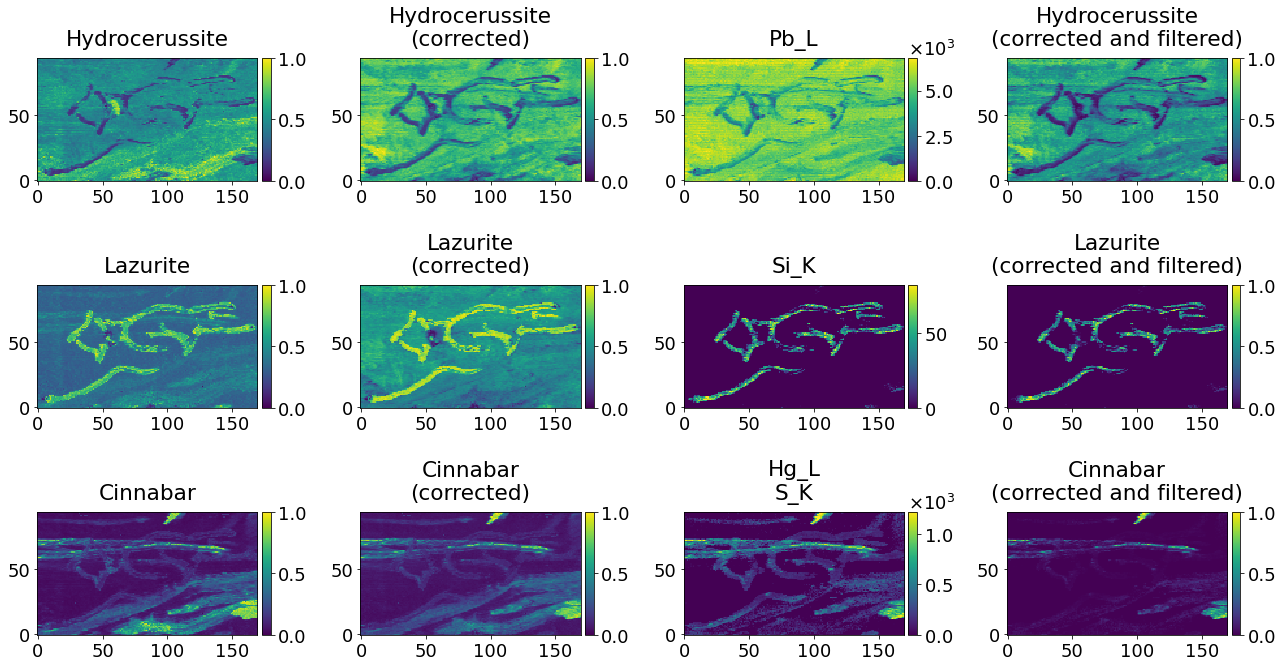

In [23]:
%matplotlib inline
rcParams['font.size'] = 18
settings_colorbar = [1.02, 0, 0.04, 1]

fig, axs = subplots(len(gm.phases), 4, figsize = (18, 3 * len(gm.phases)))
fig.tight_layout(h_pad = 4, w_pad = 2)

for i, phase in enumerate(gm.phases):
    if (len(gm.phases) > 1):
        ax = axs[i, 0]
    else:
        ax = axs[0]
    matrix_plot = overlap_area[..., i].copy()
    matrix_plot /= matrix_plot.max()
    im = ax.imshow(matrix_plot, interpolation = 'none', vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes(settings_colorbar))
    ax.set_title(phase.label, y = 1.05)
    
    if (len(gm.phases) > 1):
        ax = axs[i, 1]
    else:
        ax = axs[1]
    matrix_plot = criterion[..., i].copy()
    matrix_plot /= matrix_plot.max()
    im = ax.imshow(matrix_plot, interpolation = 'none', vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes(settings_colorbar))
    ax.set_title(phase.label + '\n(corrected)', y = 1.05)
    
    print(phase.label + ': ' + ', '.join(phase['associated elements']))
    indices_associated_elements = []
    for element in phase['associated elements']:
        j = find_element(element, data_xrf.metadata['labels'], allow_loose = False)
        if j is None:
            print(phase.label + ': ' + phase['associated element'] + ' not found')
        else:
            indices_associated_elements.append(j)
    if indices_associated_elements:        
        
        if (len(gm.phases) > 1):
            ax = axs[i, 2]
        else:
            ax = axs[2]
        map_xrf = data_xrf.labels[..., indices_associated_elements].min(axis = -1)
        im = ax.imshow(map_xrf, interpolation = 'none', vmin = 0, vmax = None)
        formatter = ScalarFormatter(useMathText = True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-2, 2))
        cb = colorbar(im, ax = ax, cax = ax.inset_axes(settings_colorbar), format = formatter)
        cb.ax.yaxis.set_offset_position('left')
        ax.set_title('\n'.join([data_xrf.metadata['labels'][idx] for idx in indices_associated_elements]), y = 1.05)
        
        if (len(gm.phases) > 1):
            ax = axs[i, 3]
        else:
            ax = axs[3]
        map_xrd = criterion[..., i] / criterion[..., i].max()
        map_xrf = map_xrf / map_xrf.max()
        map_xrd_corrected = map_xrd * map_xrf
        map_xrd_corrected /= map_xrd_corrected.max()
        im = ax.imshow(map_xrd_corrected, interpolation = 'none', vmin = 0)
        colorbar(im, ax = ax, cax = ax.inset_axes(settings_colorbar))
        ax.set_title(phase.label + '\n(corrected and filtered)', y = 1.05)

show()

# Calibrate also on specific phases

### Calibrate with hydrocerussite

In [24]:
%%time

phase_selected = 0
print(f'Calibrating with {phases_primary[phase_selected].label}...')

gm_h = GammaMap().from_data(data, phases_primary, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
    min_intensity = min_intensity, first_n_peaks = first_n_peaks)

gm_h = gm_h.search(phase_selected = phase_selected)
L1loss_h, MSEloss_h, overlap_area_h = gm_h.metrics()

Calibrating with Hydrocerussite...
Using 8 CPUs
Using 8 CPUs
CPU times: user 12.2 s, sys: 2 s, total: 14.2 s
Wall time: 19.3 s


### Calibrate with cinnabar

In [25]:
%%time

phase_selected = 2
print(f'Calibrating with {phases_primary[phase_selected].label}...')

gm_c = GammaMap().from_data(data, phases_primary, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
    min_intensity = min_intensity, first_n_peaks = first_n_peaks)

gm_c = gm_c.search(phase_selected = phase_selected)
L1loss_c, MSEloss_c, overlap_area_c = gm_c.metrics()

Calibrating with Cinnabar...
Using 8 CPUs
Using 8 CPUs
CPU times: user 11.9 s, sys: 2 s, total: 13.9 s
Wall time: 19.3 s


In [27]:
from numpy import unique
print(unique(gm.selected(), return_counts = True))
print(unique(gm_h.selected(), return_counts = True))
print(unique(gm_c.selected(), return_counts = True))

(array([0, 1, 2]), array([14269,  1479,   402]))
(array([0]), array([16150]))
(array([2]), array([16150]))


# Compare two calibrations in the same area

### Select area

Selected 400 pixels.


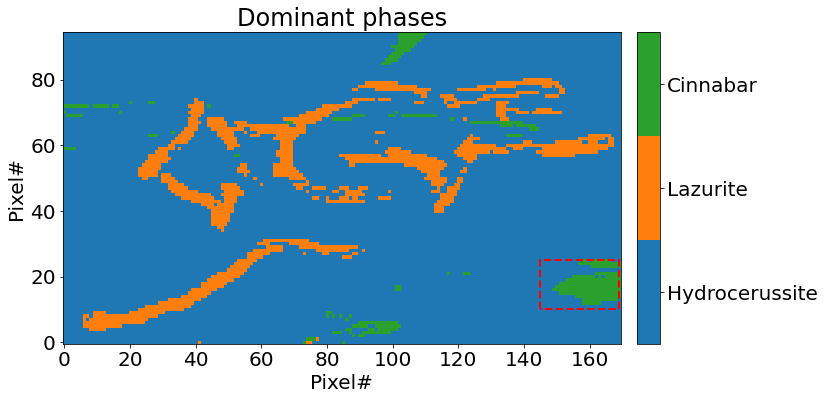

In [31]:
%matplotlib inline
rcParams['font.size'] = 20

#x_min, x_max = 153, 169
#y_min, y_max = 15, 19
x_min, x_max = 145, 169
y_min, y_max = 10, 25
#x_min, x_max = 150, 169
#y_min, y_max = 15, 22
list_x = []
list_y = []
for x in range(x_min, x_max +1 ):
    for y in range(y_min, y_max + 1):
        list_x.append(x)
        list_y.append(y)

print(f'Selected {len(list_x)} pixels.')

fig, ax = subplots(figsize = (10, 6))
cmap_chosen = get_cmap('tab10')
norm_chosen = BoundaryNorm(arange(-0.5, len(phases_primary) + 0.5, 1), len(phases_primary))
im = imshow(gm.selected(), cmap = cmap_chosen, norm = norm_chosen, interpolation = 'none')
ax.plot(
    [x_min, x_min, x_max, x_max, x_min],
    [y_min, y_max, y_max, y_min, y_min],
    ls = '--', c = 'red', lw = 2
)
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
cbar.set_ticks(range(0, len(phases_primary)))
cbar.set_ticklabels([p.label for p in phases_primary])
ax.set_title('Dominant phases')
ax.set_xlabel(r'Pixel#')
ax.set_ylabel(r'Pixel#')

savefig(path_figures + 'selected_area.png', bbox_inches = 'tight', dpi = 200)
show()

### Select pixels where cinnabar dominates

In [48]:
list_x = []
list_y = []
for x in range(data.shape[1]):
    for y in range(data.shape[0]):
        if (gm.get_pixel(x, y).idx == 2):
            list_x.append(x)
            list_y.append(y)

print(f'Selected {len(list_x)} pixels.')

Selected 402 pixels.


### Show comparison

Hydrocerussite: 400 points selected.
Cinnabar: 400 points selected.


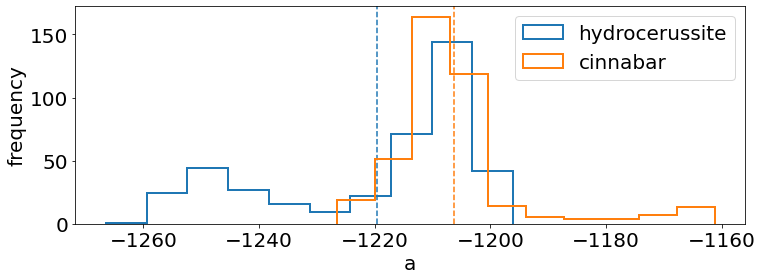

In [41]:
%matplotlib inline
rcParams['font.size'] = 20

n_bins = 10

#threshold_h = 0.3
#threshold_c = 0.5
threshold_h = None
threshold_c = None

list_filtered_a_h = []
list_filtered_s_h = []
list_filtered_a_c = []
list_filtered_s_c = []
for x, y in zip(list_x, list_y):
    if ((threshold_h is None) or (presence_hydrocerussite[y, x] <= threshold_h)):
        list_filtered_a_h.append(gm_h.get_pixel(x, y).opt[0])
        list_filtered_s_h.append(gm_h.get_pixel(x, y).opt[1])
    if ((threshold_c is None) or (presence_cinnabar[y, x] >= threshold_c)):
        list_filtered_a_c.append(gm_c.get_pixel(x, y).opt[0])
        list_filtered_s_c.append(gm_c.get_pixel(x, y).opt[1])
print(f'Hydrocerussite: {len(list_filtered_a_h)} points selected.')
print(f'Cinnabar: {len(list_filtered_a_c)} points selected.')

fig, ax = subplots(figsize = (12, 4))
ax.hist(list_filtered_a_h, n_bins, histtype = 'step', color = 'tab:blue', label = 'hydrocerussite', lw = 2)
ax.axvline(x = array(list_filtered_a_h).mean(), c = 'tab:blue', ls = '--')
ax.hist(list_filtered_a_c, n_bins, histtype = 'step', color = 'tab:orange', label = 'cinnabar', lw = 2)
ax.axvline(x = array(list_filtered_a_c).mean(), c = 'tab:orange', ls = '--')
ax.legend(loc = 'upper right')
ax.set_xlabel('a')
ax.set_ylabel('frequency')
show()

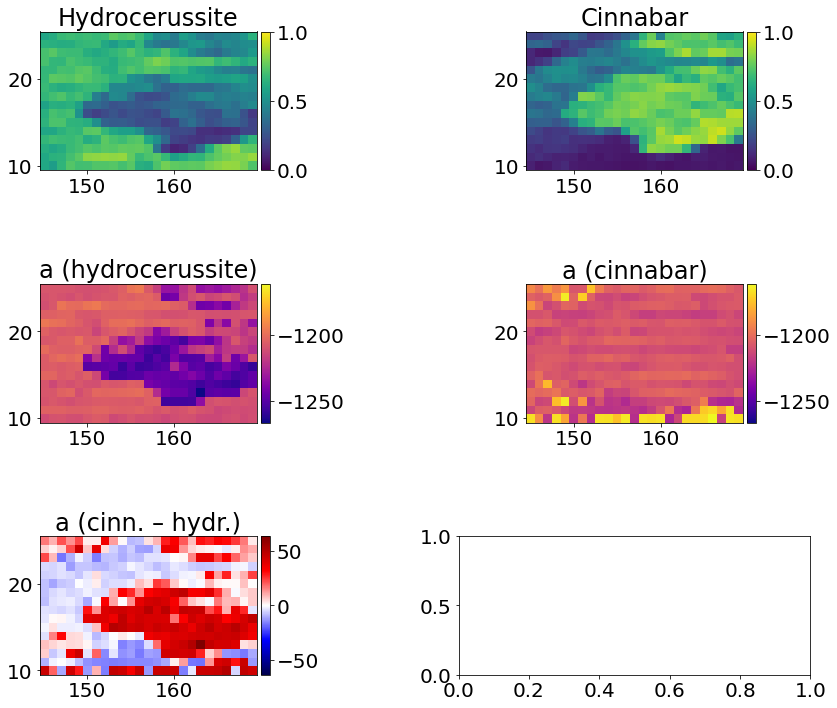

In [42]:
%matplotlib inline
rcParams['font.size'] = 20

settings_colorbar = [1.02, 0, 0.04, 1]

def default_settings(im, ax, settings_colorbar, x_min, x_max, y_min, y_max):
    ax.set_xlim(x_min - 0.5, x_max + 0.5)
    ax.set_ylim(y_min - 0.5, y_max + 0.5)
    colorbar(im, ax = ax, cax = ax.inset_axes(settings_colorbar))
    
fig, axs = subplots(3, 2, figsize = (13, 10))
fig.tight_layout(h_pad = 4, w_pad = 4)

matrix_a_c = gm_c.opt()[..., 0]
matrix_a_h = gm_h.opt()[..., 0]
matrix_a_diff = matrix_a_c - matrix_a_h
matrix_a_c_selected = matrix_a_c[y_min : y_max+1, x_min : x_max+1]
matrix_a_h_selected = matrix_a_h[y_min : y_max+1, x_min : x_max+1]
matrix_a_diff_selected = matrix_a_diff[y_min : y_max+1, x_min : x_max+1]

vmax_a = max(matrix_a_c_selected.max(), matrix_a_h_selected.max())
vmin_a = min(matrix_a_c_selected.min(), matrix_a_h_selected.min())
vmax_diff = max(abs(matrix_a_diff_selected.min()), abs(matrix_a_diff_selected.max()))
vmin_diff = - vmax_diff

ax = axs[0, 0]
im = ax.imshow(presence_hydrocerussite, interpolation = 'none', vmin = 0)
default_settings(im, ax, settings_colorbar, x_min, x_max, y_min, y_max)
ax.set_title('Hydrocerussite')

ax = axs[0, 1]
im = ax.imshow(presence_cinnabar, interpolation = 'none', vmin = 0)
default_settings(im, ax, settings_colorbar, x_min, x_max, y_min, y_max)
ax.set_title('Cinnabar')

ax = axs[1, 0]
im = ax.imshow(matrix_a_h, interpolation = 'none', vmin = vmin_a, vmax = vmax_a, cmap = 'plasma')
default_settings(im, ax, settings_colorbar, x_min, x_max, y_min, y_max)
ax.set_title('a (hydrocerussite)')

ax = axs[1, 1]
im = ax.imshow(matrix_a_c, interpolation = 'none', vmin = vmin_a, vmax = vmax_a, cmap = 'plasma')
default_settings(im, ax, settings_colorbar, x_min, x_max, y_min, y_max)
ax.set_title('a (cinnabar)')

ax = axs[2, 0]
im = ax.imshow(matrix_a_diff, interpolation = 'none', vmin = vmin_diff, vmax = vmax_diff, cmap = 'seismic')
default_settings(im, ax, settings_colorbar, x_min, x_max, y_min, y_max)
ax.set_title('a (cinn. – hydr.)')

show()

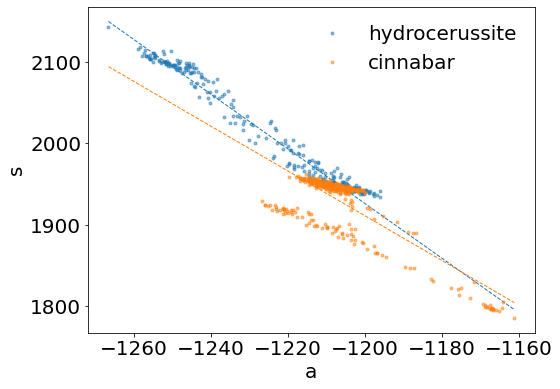

In [40]:
%matplotlib inline
rcParams['font.size'] = 20

x = linspace(min(list_filtered_a_h + list_filtered_a_c), max(list_filtered_a_h + list_filtered_a_c), 10)
opt_h, var_h = curve_fit(f_linear, list_filtered_a_h, list_filtered_s_h)
opt_c, var_c = curve_fit(f_linear, list_filtered_a_c, list_filtered_s_c)

fig, ax = subplots(figsize = (8, 6))
ax.plot(list_filtered_a_h, list_filtered_s_h, '.', c = 'tab:blue', alpha = 0.5, label = 'hydrocerussite')
ax.plot(x, f_linear(x, *opt_h), ls = '--', lw = 1, c = 'tab:blue')
ax.plot(list_filtered_a_c, list_filtered_s_c, '.', c = 'tab:orange', alpha = 0.5, label = 'cinnabar')
ax.plot(x, f_linear(x, *opt_c), ls = '--', lw = 1, c = 'tab:orange')
ax.legend(frameon = False)
ax.set_xlabel('a')
ax.set_ylabel('s')
show()

# Compare two different areas when calibration is based on hydrocerussite

### Select areas

Selected 64 and 600 pixels.


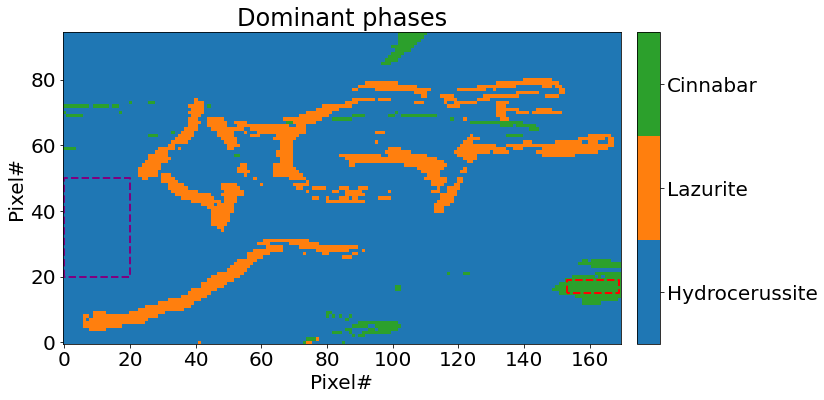

In [41]:
%matplotlib inline
rcParams['font.size'] = 20

x_min_1, x_max_1 = 153, 169
y_min_1, y_max_1 = 15, 19
x_min_2, x_max_2 = 0, 20
y_min_2, y_max_2 = 20, 50
color_1 = 'red'
color_2 = 'purple'

list_1_x = []
list_1_y = []
for x in range(x_min_1, x_max_1):
    for y in range(y_min_1, y_max_1):
        list_1_x.append(x)
        list_1_y.append(y)
list_2_x = []
list_2_y = []
for x in range(x_min_2, x_max_2):
    for y in range(y_min_2, y_max_2):
        list_2_x.append(x)
        list_2_y.append(y)
print(f'Selected {len(list_1_x)} and {len(list_2_x)} pixels.')

fig, ax = subplots(figsize = (10, 6))
cmap_chosen = get_cmap('tab10')
norm_chosen = BoundaryNorm(arange(-0.5, len(phases_primary) + 0.5, 1), len(phases_primary))
im = imshow(gm.selected(), cmap = cmap_chosen, norm = norm_chosen)
ax.plot(
    [x_min_1, x_min_1, x_max_1, x_max_1, x_min_1],
    [y_min_1, y_max_1, y_max_1, y_min_1, y_min_1],
    ls = '--', c = color_1, lw = 2
)
ax.plot(
    [x_min_2, x_min_2, x_max_2, x_max_2, x_min_2],
    [y_min_2, y_max_2, y_max_2, y_min_2, y_min_2],
    ls = '--', c = color_2, lw = 2
)
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
cbar.set_ticks(range(0, len(phases_primary)))
cbar.set_ticklabels([p.label for p in phases_primary])
ax.set_title('Dominant phases')
ax.set_xlabel(r'Pixel#')
ax.set_ylabel(r'Pixel#')

savefig(path_figures + 'selected_area.png', bbox_inches = 'tight', dpi = 200)
show()

### Show comparison

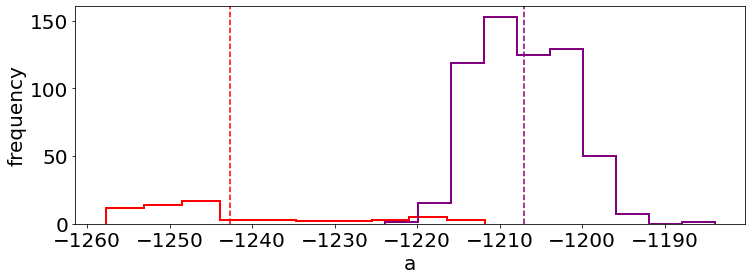

In [42]:
%matplotlib inline
rcParams['font.size'] = 20

n_bins = 10
#n_bins = len(list_x) // 10
#print(f'Automatically chosen {n_bins} bins')

list_1_a = []
list_1_s = []
list_2_a = []
list_2_s = []
for x, y in zip(list_1_x, list_1_y):
    list_1_a.append(gm_h.get_pixel(x, y).opt[0])
    list_1_s.append(gm_h.get_pixel(x, y).opt[1])
for x, y in zip(list_2_x, list_2_y):
    list_2_a.append(gm_h.get_pixel(x, y).opt[0])
    list_2_s.append(gm_h.get_pixel(x, y).opt[1])

fig, ax = subplots(figsize = (12, 4))
ax.hist(list_1_a, n_bins, histtype = 'step', color = color_1, label = 'area 1', lw = 2)
ax.axvline(x = array(list_1_a).mean(), c = color_1, ls = '--')
ax.hist(list_2_a, n_bins, histtype = 'step', color = color_2, label = 'area 2', lw = 2)
ax.axvline(x = array(list_2_a).mean(), c = color_2, ls = '--')
#ax.legend(frameon = False)
ax.set_xlabel('a')
ax.set_ylabel('frequency')
show()

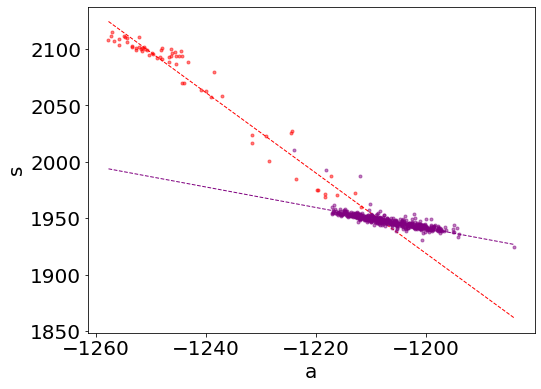

In [43]:
%matplotlib inline
rcParams['font.size'] = 20

x = linspace(min(list_1_a + list_2_a), max(list_1_a + list_2_a), 10)
opt_1, var_1 = curve_fit(f_linear, list_1_a, list_1_s)
opt_2, var_2 = curve_fit(f_linear, list_2_a, list_2_s)

fig, ax = subplots(figsize = (8, 6))
ax.plot(list_1_a, list_1_s, '.', c = color_1, alpha = 0.5, label = 'area 1')
ax.plot(x, f_linear(x, *opt_1), ls = '--', lw = 1, c = color_1)
ax.plot(list_2_a, list_2_s, '.', c = color_2, alpha = 0.5, label = 'area 2')
ax.plot(x, f_linear(x, *opt_2), ls = '--', lw = 1, c = color_2)
#ax.legend(frameon = False)
ax.set_xlabel('a')
ax.set_ylabel('s')
show()